In [10]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))
from scipy.io import loadmat
from pathlib import Path
import matplotlib.patches as patches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
# the following import is required for matplotlib < 3.2:
from mpl_toolkits.mplot3d import Axes3D  # noqa
from scipy import stats
from scipy.stats import mannwhitneyu, ttest_rel
from scipy.signal import butter, filtfilt
import mne
import eeg_analysis.funcs4eeg as fe
import re
import imp
import ast
import behavior.func4behav as fb
imp.reload(fe)
imp.reload(fb)

from scipy import signal
from scipy.signal import resample
from scipy.ndimage import zoom

In [32]:
# combine fast and slow
case_title = 'endo'
case_list = [case_title+' fast', case_title+' slow']
tmax_list = [1.5+1+0.5+0.05+1, 1.5+1+1+0.05+1]

# case_title = 'exo'
# case_list = [case_title+' fast', case_title+' slow']
# tmax_list = [1.5+0.033*4+0.5+0.05+1, 1.5+0.033*4+1+0.05+1]

fs = 1200
eeg_fast = np.empty((0, 32, int(tmax_list[0]*fs)+1))
eeg_slow = np.empty((0, 32, int(tmax_list[1]*fs)+1))
rt = np.empty((0,))
for i, case in enumerate(case_list):
    tmax = tmax_list[i]
    watch = '1 fixation'
    tmin = 0 # include fix or not?

    highpass = None # 0.3
    lowpass = None

    EP_lists, RT_lists = fe.pipeline_EP_RT(case, watch, tmin, tmax, hipass=highpass, lopass=lowpass, baseline=(0,0), move_baseline=False, detrend=1)
    eeg_tmp = np.vstack([EP_lists[0], EP_lists[2]]) # only for all before
    
    # make eeg to same length
    if 'slow' in case:
        eeg_slow = np.vstack((eeg_slow, eeg_tmp))
    else:
        eeg_fast = np.vstack((eeg_fast, eeg_tmp))

    rt_tmp = np.hstack([RT_lists[0], RT_lists[2]])
    rt = np.hstack((rt, rt_tmp))


In [33]:
freq_bands = [[4, 8], [8, 12], [12, 30], [30, 50]]
endo_fast_stages = [[0, 1.5], [1.5, 1.5+1], [1.5+1, 1.5+1+0.5], [1.5+1+0.5, 1.5+1+0.5+0.05], [1.5+1+0.5+0.05, 1.5+1+0.5+0.05+1-0.001]]
endo_slow_stages = [[0, 1.5], [1.5, 1.5+1], [1.5+1, 1.5+1+1], [1.5+1+1, 1.5+1+1+0.05], [1.5+1+1+0.05, 1.5+1+1+0.05+1-0.001]]
exo_fast_stages = [[0, 1.5], [1.5, 1.5+0.033*4], [1.5+0.033*4, 1.5+0.033*4+0.5], [1.5+0.033*4+0.5, 1.5+0.033*4+0.5+0.05], [1.5+0.033*4+0.5+0.05, 1.5+0.033*4+0.5+0.05+1-0.001]]
exo_slow_stages = [[0, 1.5], [1.5, 1.5+0.033*4], [1.5+0.033*4, 1.5+0.033*4+1], [1.5+0.033*4+1, 1.5+0.033*4+1+0.05], [1.5+0.033*4+1+0.05, 1.5+0.033*4+1+0.05+1-0.001]]

In [74]:
bp_table = np.zeros((eeg_fast.shape[0]+eeg_slow.shape[0], 32, 5, 4)) # trials, 32 channels, 5 stages, 4 frequency bands
eeg_list = [eeg_fast, eeg_slow]
if 'endo' in case_title:
    stages_list = [endo_fast_stages, endo_slow_stages]
else:
    stages_list = [exo_fast_stages, exo_slow_stages]

adjust = 0
for i, eeg in enumerate(eeg_list):
    stages = stages_list[i]
    # add stim channel
    stim = np.zeros((1, eeg.shape[2]))
    stim[0,1] = 1

    for trial in range(eeg.shape[0]):
        data = eeg[trial,:,:]
        one_trial = np.vstack((data, stim))
        one_epoch = fe.makeup_subject(one_trial, tmin=0, tmax=stages[-1][-1], baseline=None)
        for j, stage in enumerate(stages):
            psds, freqs = mne.time_frequency.psd_array_multitaper(data, fs, fmin=0, fmax=51, verbose=False)
            for channel in range(eeg.shape[1]):
                for k,band in enumerate(freq_bands):
                    # power = fe.band_power(data, band)
                    bp_table[trial+adjust, channel, j, k] = 1 # power

    adjust = eeg.shape[0]



KeyboardInterrupt: 

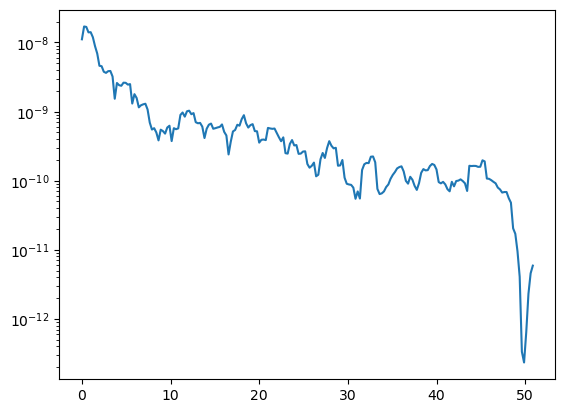

In [79]:
plt.plot(freqs, psds[30,:])
plt.yscale('log')

c:\ProgramData\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:161: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


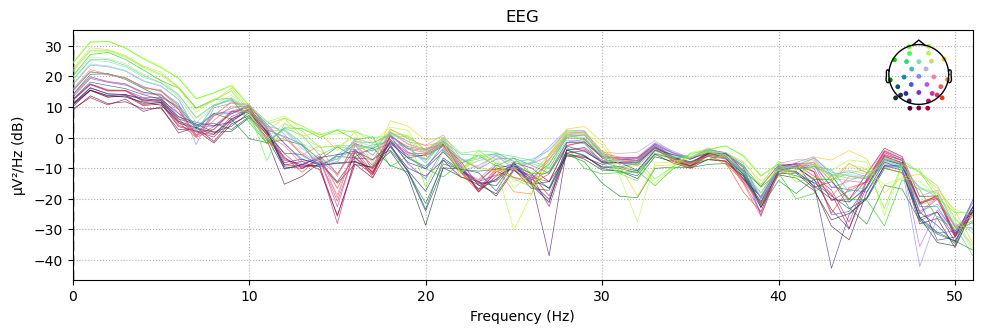

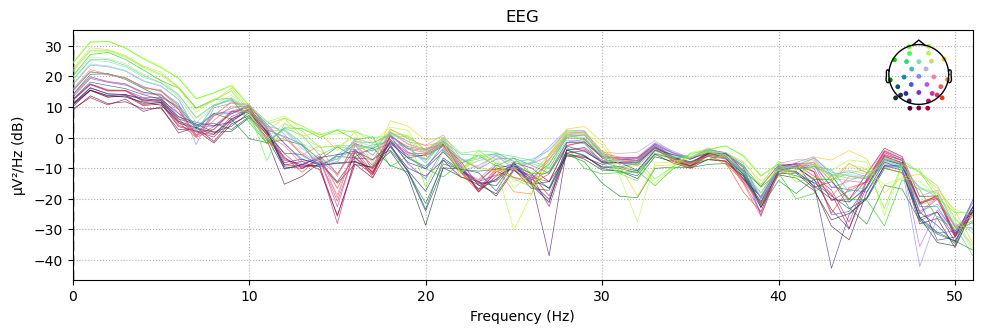

In [57]:
a = psd.get_data()
psd.plot()

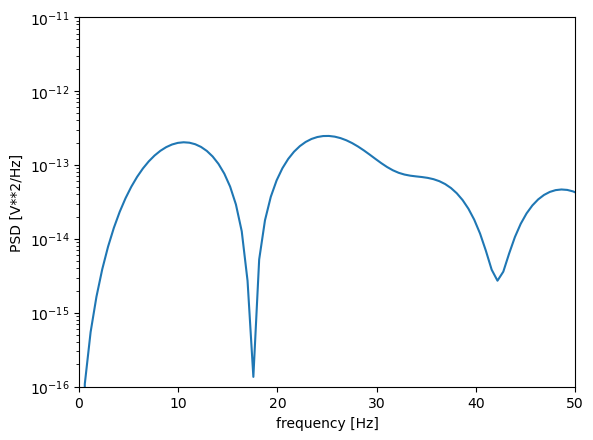

0.0


In [127]:
data = eeg_fast[0, 0, 1000:1120]
fs = 1200
f, Pxx_den = signal.periodogram(data, fs, nfft=2048, scaling='density')
plt.semilogy(f, Pxx_den)
plt.ylim([1e-16, 1e-11])
plt.xlim([0, 50])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

f_start = fe.find_closest_index(f, 1000)
f_end = fe.find_closest_index(f, 2000)
power = sum(Pxx_den[f_start:f_end]) * (f[10]-f[9])
print(power)

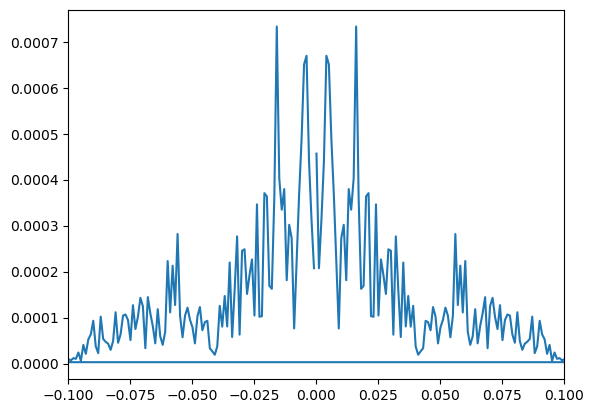

In [104]:
import matplotlib.pyplot as plt
data = eeg_fast[0, 0, 1000:2000]

# t = np.arange(256)
# sp = np.fft.fft(np.sin(t))
sp = np.fft.fft(data)
freq = np.fft.fftfreq(len(data))
plt.plot(freq, abs(sp))
plt.xlim(-0.1, 0.1)
plt.show()

In [88]:
# Compute FFT of the data
data = eeg_fast[0, 0, 1000:1200]
band = [4,8]
fs = 1200
f_values = np.fft.fftfreq(len(data), 1/fs)
fft_values = np.fft.fft(data)

# Get indices for the frequency band


# Compute power
power = np.sum(np.abs(fft_values[idx_band])**2) * (f_values[1] - f_values[0])
print(power)

1.911920271300347e-07


In [99]:
len(data)

200